# <br><br> Strategy Description: BTC risk-Off based on Equity Market signals and BTC Trend

This strategy dynamically reduces exposure to Bitcoin during periods of elevated macro risk, combining two types of signals:

1. **Cross-Market Risk Signal (Equity-Based)**  
   We use a composite model originally designed for the S&P 500, which combines:
   - Breadth indicators (e.g., Advance-Decline, New High–New Low, VIX z-score)
   - High-yield credit spread stress, detected via a Thomas Count-like approach

   When this model flags a **risk-off regime in equities**, we interpret it as a signal to reduce exposure in BTC as well — reflecting the increasing correlation between crypto and traditional markets during periods of stress.

2. **BTC Trend Signal**  
   In parallel, we monitor a simple trend-following indicator on BTC itself (e.g., moving average slope or price below long-term average).  
   If the trend is **negative**, we also move to a defensive stance, regardless of equity market conditions.

The strategy enters **risk-off mode** if either:
- The equity-based model turns risk-off  
- The BTC trend is negative

This dual-layer logic helps manage downside exposure while staying aligned with broader market conditions.

# <br><br> Imports

In [1]:
from requests import get
import pandas as pd
import numpy as np

import plotly.io as pio
pio.renderers.default = 'notebook'

import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.colors import sample_colorscale

import time
import sys
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

import vectorbt as vbt
import arcticdb as adb
from scipy.stats import rankdata

import arcticdb as adb

from fredapi import Fred

# <br><br> Built-in functions

In [2]:
from typing import List, Union

def get_historical_klines(symbol: str, start_date: float, interval: str = '1h', spot: bool = True) -> pd.DataFrame:
    """
    Retrieve historical OHLC data from Binance Spot or Futures (Perpetual) API.

    Parameters
    ----------
    symbol : str
        Trading pair symbol (e.g., 'BTCUSDT').
    start_date : float
        Start date as a Unix timestamp in seconds.
    interval : str, optional
        Kline interval (default is '1h').
    spot : bool, optional
        Market type: True if Spot, False if Perp (default is True).

    Returns
    -------
    pd.DataFrame
        DataFrame with historical OHLCV data and calculated CVD approximation.
    """
    start_ms = int(start_date * 1e3)
    end_ms = int((time.time() - 300) * 1e3)  # 5 min buffer

    base_url = 'https://api4.binance.com/api/v3/klines' if spot else 'https://fapi.binance.com/fapi/v1/klines'

    all_data = []
    current_start = start_ms
    max_retries = 3

    def fetch_klines(start_ts: int, end_ts: int) -> pd.DataFrame:
        url = f"{base_url}?symbol={symbol}&interval={interval}&startTime={start_ts}&endTime={end_ts}&limit=1000"
        for attempt in range(max_retries):
            try:
                res = np.array(get(url).json())
                if len(res) == 0:
                    return pd.DataFrame()
                df = pd.DataFrame({
                    'timestamp': res[:, 0],
                    'open': res[:, 1],
                    'high': res[:, 2],
                    'low': res[:, 3],
                    'close': res[:, 4],
                }).astype(float)
                return df
            except Exception as e:
                if attempt == max_retries - 1:
                    raise Exception(f"Failed to fetch data after {max_retries} attempts.") from e
                time.sleep(5)

    # Main download loop
    while current_start < end_ms:
        batch = fetch_klines(current_start, end_ms)
        if batch.empty:
            break
        all_data.append(batch)
        current_start = int(batch['timestamp'].max()) + 1
        if len(batch) < 1000:
            break

    df = pd.concat(all_data).drop_duplicates('timestamp')
    df.sort_values(by='timestamp', inplace=True)
    df['timestamp'] /= 1e3
    df.index = range(len(df))

    return df


def cumulative_percentile(
    series: pd.Series,
    rolling_window: Union[int, float] = 1e10,
    show_progress: bool = True
) -> pd.Series:
    """
    Computes the cumulative percentile of each value in a time series,
    optionally within a rolling window.

    Parameters
    ----------
    series : pd.Series
        The input time series.
    rolling_window : int or float, optional
        Number of past values to consider (including current). If large (default=1e10),
        computes percentiles over the entire history up to each point.
    show_progress : bool, optional
        Whether to show a tqdm progress bar.

    Returns
    -------
    pd.Series
        A series of percentiles (0–100) for each value, aligned with the original index.
    """
    percentiles = []
    iterator = tqdm(range(len(series))) if show_progress else range(len(series))

    for i in iterator:
        # Define the rolling window range
        start = max(0, int(i - rolling_window))
        current_values = series[start:i + 1].dropna()

        # Handle edge cases
        if len(current_values) == 0 or np.isnan(series.values[i]):
            percentiles.append(np.nan)
            continue

        # Rank the current values
        ranks = rankdata(current_values)
        percentile = (ranks[-1] - 1) / (len(current_values) - 1) * 100
        percentiles.append(percentile)

    return pd.Series(percentiles, index=series.index)

# <br><br> Equity market data download, and generation of signals
- VIX/VIX3M ema crossover
- SPY realized volatility
- NYSE Adv-Dec zscore
- NYSE+NASDAQ NH-NL zscore
- Credit spread of High-Yield corporate bonds zscore

you are using nologin method, data you access may be limited


SPX,QQQ


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.28s/it]


NY,NQ breadth


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:12<00:00,  3.01s/it]


Credit Spread


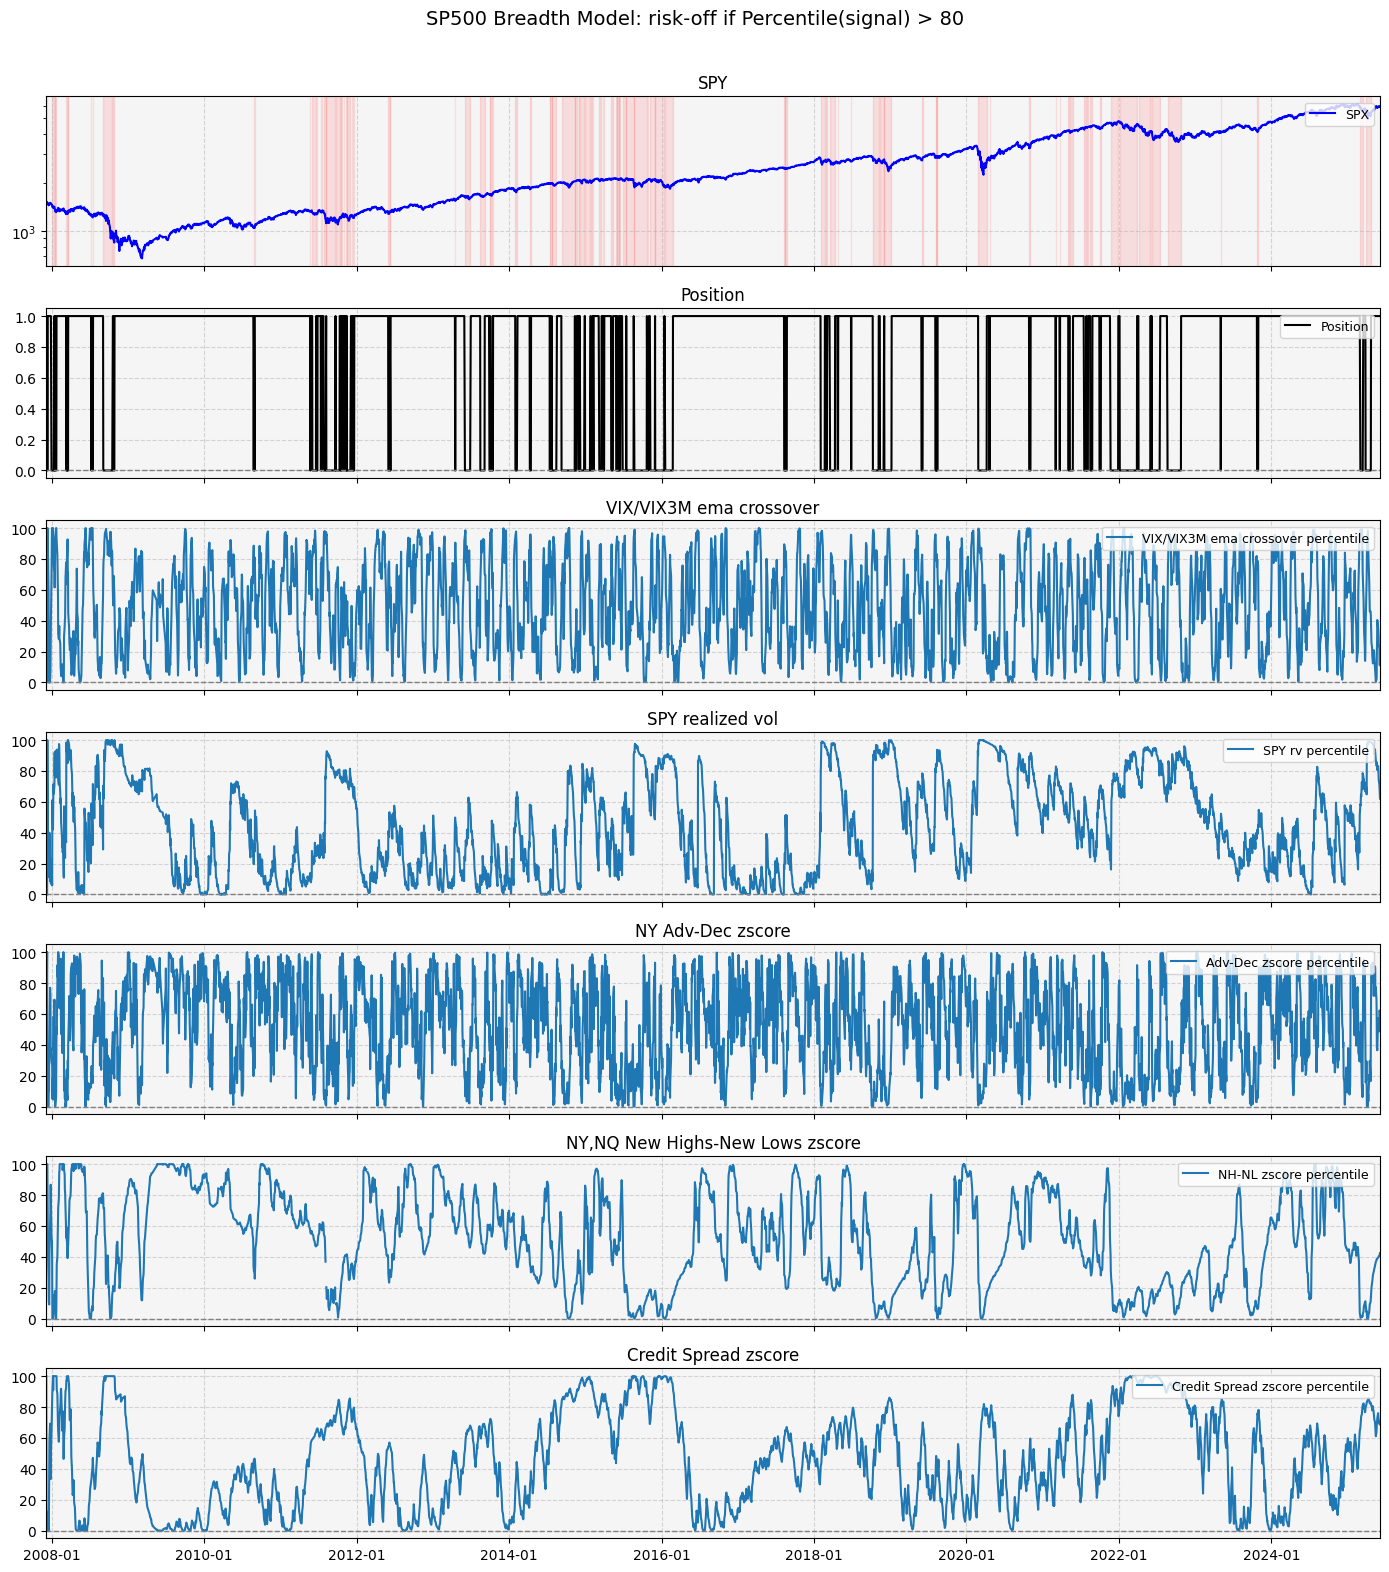

In [3]:
from tvDatafeed import TvDatafeed, Interval

tv = TvDatafeed()
p_window = 5*252

# ====================================================================================
# SPX, QQQ
# ====================================================================================
print('SPX,QQQ')

spx = tv.get_hist(symbol='SPX',exchange='INDEX',interval=Interval.in_daily,n_bars=6000)
ndx = tv.get_hist(symbol='NDX',exchange='INDEX',interval=Interval.in_daily,n_bars=6000)
vix = tv.get_hist(symbol='VIX',exchange='INDEX',interval=Interval.in_daily,n_bars=6000)
vix3m = tv.get_hist(symbol='VIX3M',exchange='INDEX',interval=Interval.in_daily,n_bars=6000)

spx['SPX_close'] = spx['close']
spx['SPX_open'] = spx['open']
ndx['NDX_close'] = ndx['close']
ndx['NDX_open'] = ndx['open']
vix['VIX_close'] = vix['close']
vix3m['VIX3M_close'] = vix3m['close']

spx = spx[['SPX_open', 'SPX_close']]
ndx = ndx[['NDX_open', 'NDX_close']]
vix = vix[['VIX_close']]
vix3m = vix3m[['VIX3M_close']]

etf = pd.merge(spx, ndx, left_index=True, right_index=True)
etf = pd.merge(etf, vix, left_index=True, right_index=True)
etf = pd.merge(etf, vix3m, left_index=True, right_index=True)

etf['date'] = etf.index
etf['date'] = etf['date'].dt.date
etf.index = range(len(etf))

rv_periods = [
    10,
    20,
    40
]
for period in tqdm(rv_periods):
    etf[f'rv_spy_{period}'] = etf['SPX_close'].pct_change().ewm(span=period).std()
    etf[f'rv_spy_{period}'] = cumulative_percentile(etf[f'rv_spy_{period}'], p_window, False)

signals = [f'rv_spy_{p}' for p in rv_periods]
etf['rv_signal'] = cumulative_percentile(etf[signals].mean(axis=1), p_window, False)

etf['vix_vix3m'] = etf['VIX_close'] / etf['VIX3M_close']
etf['vix_vix3m_zscore'] = (etf['vix_vix3m'].ewm(span=7).mean() - 
                          etf['vix_vix3m'].ewm(span=12).mean()) / \
                            etf['vix_vix3m'].ewm(span=12).std()

etf = etf[['date', 'SPX_open', 'SPX_close', 'NDX_open', 'NDX_close', 'rv_signal', 'VIX_close', 'VIX3M_close', 'vix_vix3m_zscore']]

# ====================================================================================
# NY,NQ breadth
# ====================================================================================
print('NY,NQ breadth')
tickers = [
    ['ADVN.NY', 'DECL.NY', 'ADV', 'DECL'],
    ['ADVN.NQ', 'DECL.NQ', 'ADV', 'DECL'],
    ['MAHN', 'MALN', 'HIGN', 'LOWN'],
    ['MAHQ', 'MALQ', 'HIGQ', 'LOWQ']
]
exchanges = [
    ['USI']*4,
    ['USI']*4,
    ['INDEX']*4,
    ['INDEX']*4
]

signals = [
    ['ny_adv', 'ny_dec'],
    ['nq_adv', 'nq_dec'],
    ['ny_nh', 'ny_nl'],
    ['nq_nh', 'nq_nl']
]
for ts, exs, ss in tqdm(zip(tickers, exchanges, signals), total=len(signals)):
    # Read data
    # df_1 = ac['tvDatafeed'][ts[0]].data
    # df_2 = ac['tvDatafeed'][ts[1]].data
    # df_1_pre = ac['tvDatafeed'][ts[2]].data
    # df_2_pre = ac['tvDatafeed'][ts[3]].data
    df_1 = tv.get_hist(symbol=ts[0],exchange=exs[0],interval=Interval.in_daily,n_bars=6000)
    df_2 = tv.get_hist(symbol=ts[1],exchange=exs[1],interval=Interval.in_daily,n_bars=6000)
    df_1_pre = tv.get_hist(symbol=ts[2],exchange=exs[2],interval=Interval.in_daily,n_bars=6000)
    df_2_pre = tv.get_hist(symbol=ts[3],exchange=exs[3],interval=Interval.in_daily,n_bars=6000)

    # Rename
    df_1[ss[0]] = df_1['close']
    df_1 = df_1[[ss[0]]]
    
    df_2[ss[1]] = df_2['close']
    df_2 = df_2[[ss[1]]]
    
    df_1_pre[f'{ss[0]}_pre'] = df_1_pre['close']
    df_1_pre = df_1_pre[[f'{ss[0]}_pre']]
    
    df_2_pre[f'{ss[1]}_pre'] = df_2_pre['close']
    df_2_pre = df_2_pre[[f'{ss[1]}_pre']]
    
    # Calculate ratio
    df_aux = pd.merge(df_1, df_1_pre, left_index=True, right_index=True, how='inner')
    ratio_1 = np.mean((df_aux[ss[0]] / df_aux[f'{ss[0]}_pre']).values[:100])
    
    df_aux = pd.merge(df_2, df_2_pre, left_index=True, right_index=True, how='inner')
    ratio_2 = np.mean((df_aux[ss[1]] / df_aux[f'{ss[1]}_pre']).values[:100])
    
    # Merge
    data = pd.merge(df_1, df_2, left_index=True, right_index=True, how='outer')
    data = pd.merge(data, df_1_pre, left_index=True, right_index=True, how='outer')
    data = pd.merge(data, df_2_pre, left_index=True, right_index=True, how='outer')
    
    # Backfill
    data[ss[0]] = data[ss[0]].fillna(data[f'{ss[0]}_pre'] * ratio_1)
    data[ss[1]] = data[ss[1]].fillna(data[f'{ss[1]}_pre'] * ratio_2)
    data['date'] = data.index
    data['date'] = data['date'].dt.date
    data.index = range(len(data))
    data = data[['date', ss[0], ss[1]]]

    if ts == tickers[0]:
        ny_nq_breadth = data.copy()
    else:
        ny_nq_breadth = pd.merge(ny_nq_breadth, data, on='date', how='inner')

ny_nq_breadth['ad_ny'] = ny_nq_breadth['ny_adv'] - ny_nq_breadth['ny_dec']
ny_nq_breadth['ad_nq'] = ny_nq_breadth['nq_adv'] - ny_nq_breadth['nq_dec']
ny_nq_breadth['hl_ny'] = ny_nq_breadth['ny_nh'] - ny_nq_breadth['ny_nl']
ny_nq_breadth['hl_nq'] = ny_nq_breadth['nq_nh'] - ny_nq_breadth['nq_nl']

ny_nq_breadth['ad_zscore_ny'] = (ny_nq_breadth['ad_ny'].cumsum() - ny_nq_breadth['ad_ny'].cumsum().ewm(span=21).mean()) / \
                                ny_nq_breadth['ad_ny'].cumsum().ewm(span=21).std()

ny_nq_breadth['hl_ny_nq'] = ny_nq_breadth['hl_ny'] + ny_nq_breadth['hl_nq']
ny_nq_breadth['hl_zscore_ny_nq'] = (ny_nq_breadth['hl_ny_nq'].cumsum() - ny_nq_breadth['hl_ny_nq'].cumsum().ewm(span=40).mean()) / \
                                    ny_nq_breadth['hl_ny_nq'].cumsum().ewm(span=40).std()

# ====================================================================================
# Credit Spread
# ====================================================================================
print('Credit Spread')
ticker = 'BAMLH0A0HYM2'
api_key = '602df0dfcd95910a9b540ee2781049f8'
fred = Fred(api_key=api_key)
credit_spread = fred.get_series(ticker)
credit_spread = pd.DataFrame({
    'date': credit_spread.index,
    'credit_spread': credit_spread.values
})

credit_spread['date'] = pd.to_datetime(credit_spread['date'])
credit_spread['date'] = credit_spread['date'].dt.date

tc_window = 5
credit_spread['credit_spread_tc'] = 0.
credit_spread.loc[credit_spread['credit_spread'] > credit_spread['credit_spread'].shift(tc_window), 'credit_spread_tc'] = 1
credit_spread.loc[credit_spread['credit_spread'] < credit_spread['credit_spread'].shift(tc_window), 'credit_spread_tc'] = -1
credit_spread['credit_spread_tc'] = credit_spread['credit_spread_tc'].cumsum()

credit_spread['cs_zscore'] = (credit_spread['credit_spread_tc'] - credit_spread['credit_spread_tc'].ewm(span=252).mean()) / \
                            credit_spread['credit_spread_tc'].ewm(span=252).std()


credit_spread = credit_spread[['date', 'credit_spread_tc', 'cs_zscore']]

# ====================================================================================
# Breadth model
# ====================================================================================
breadth = pd.merge(etf, ny_nq_breadth, how='inner', on='date')
breadth = pd.merge(breadth, credit_spread, how='inner', on='date')

breadth['ad_zscore_ny_p'] = cumulative_percentile(breadth['ad_zscore_ny'], p_window, False)
breadth['hl_zscore_ny_nq_p'] = cumulative_percentile(breadth['hl_zscore_ny_nq'], p_window, False)
breadth['cs_zscore_p'] = cumulative_percentile(breadth['cs_zscore'], p_window, False)
breadth['vix_vix3m_zscore_p'] = cumulative_percentile(breadth['vix_vix3m_zscore'], p_window, False)
breadth['spy_rv'] = breadth['SPX_close'].pct_change().ewm(span=21).std() * np.sqrt(252)
breadth['spy_rv_p'] = cumulative_percentile(breadth['spy_rv'], p_window, False)

breadth['signal'] = - breadth['ad_zscore_ny_p'] - breadth['hl_zscore_ny_nq_p'] + 2 * breadth['cs_zscore_p'] + \
                        + breadth['spy_rv_p'] + breadth['vix_vix3m_zscore_p']
breadth['signal'] = cumulative_percentile(breadth['signal'], p_window, False)
            
breadth['breadth_position'] = 1
breadth.loc[breadth['signal'] > 80, 'breadth_position'] = 0

# ====================================================================================
# Plot results
# ====================================================================================
# ---------------------------------------------
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# --- Setup
fig, axes = plt.subplots(7, 1, figsize=(14, 16), sharex=True)
plt.subplots_adjust(hspace=0.35)
fig.suptitle("SP500 Breadth Model: risk-off if Percentile(signal) > 80", fontsize=14)

# --- Subplot 1: SPX
axes[0].plot(breadth['date'], breadth['SPX_close'], label='SPX', color='blue', linewidth=1.5)
axes[0].set_title('SPY')

# --- Subplot 2: Position
axes[1].plot(breadth['date'], breadth['breadth_position'], label='Position', color='black', linewidth=1.5)
axes[1].set_title('Position')

# --- Subplot 3: VIX/VIX3M
axes[2].plot(breadth['date'], breadth['vix_vix3m_zscore_p'], label='VIX/VIX3M ema crossover percentile', linewidth=1.5)
axes[2].set_title('VIX/VIX3M ema crossover')

# --- Subplot 4: SPY realized vol
axes[3].plot(breadth['date'], breadth['spy_rv_p'], label='SPY rv percentile', linewidth=1.5)
axes[3].set_title('SPY realized vol')

# --- Subplot 4: Advance-Decline NYSE
axes[4].plot(breadth['date'], breadth['ad_zscore_ny_p'], label='Adv-Dec zscore percentile', linewidth=1.5)
axes[4].set_title('NY Adv-Dec zscore')

# --- Subplot 5: New Highs - New Lows
axes[5].plot(breadth['date'], breadth['hl_zscore_ny_nq_p'], label='NH-NL zscore percentile', linewidth=1.5)
axes[5].set_title('NY,NQ New Highs-New Lows zscore')

# --- Subplot 6: Credit Spread
axes[6].plot(breadth['date'], breadth['cs_zscore_p'], label='Credit Spread zscore percentile', linewidth=1.5)
axes[6].set_title('Credit Spread zscore')

# --- Styling
for ax in axes:
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(loc='upper right', fontsize=9)
    ax.axhline(0, color='grey', linestyle='--', linewidth=1)
    ax.set_facecolor('whitesmoke')

# Date formatting
axes[-1].xaxis.set_major_locator(mdates.AutoDateLocator())
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

axes[0].set_yscale('log')

xmin = breadth['date'].min()
xmax = breadth['date'].max()
for ax in axes:
    ax.set_xlim([xmin, xmax])

# --- Añadir bandas verticales para periodos risk-off (position == 0)
from itertools import groupby
from operator import itemgetter

# Convertimos fechas a numpy para mayor rendimiento
dates = np.array(breadth['date'])
position = np.array(breadth['breadth_position'])

# Encontramos índices donde position == 0
risk_off_indices = np.where(position == 0)[0]

# Agrupar los índices consecutivos
for k, g in groupby(enumerate(risk_off_indices), lambda x: x[0] - x[1]):
    group = list(map(itemgetter(1), g))
    start_date = dates[group[0]]
    end_date = dates[group[-1]]
    axes[0].axvspan(start_date, end_date, color='red', alpha=0.1)


plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# <br><br> BTC data download

In [4]:
# ----------------------------------------
# Download BTC historical data
start_date = time.time() - 20*365*24*3600

data = get_historical_klines('BTCUSDT', start_date, '1d', True)
data['date'] = pd.to_datetime(data['timestamp'], unit='s')
data['date'] = data['date'].dt.date
data['BTC_close'] = data['close']
data = data[['date', 'BTC_close']]

# ----------------------------------------
data = pd.merge(data, breadth, on='date', how='inner')

# <br><br> Generation of BTC Trend signal, combining different indicators
- Spread between moving averages, called Trend.
- Acceleration, second order effect.
- Bollinger-Bands

In [5]:
# ---------------------------
# EWMAC
spans = [
    4,
    8,
    16,
    32,
    64,
]
for span in spans:
    # Difference between Short and Long EMA
    data[f'BTC_trend_{span}'] = data['BTC_close'].ewm(span=span).mean() - data['BTC_close'].ewm(span=4*span).mean()
    
    # Normalize by the average value of the signal
    data[f'BTC_trend_{span}'] /= np.abs(data[f'BTC_trend_{span}']).expanding().mean()

    # Clip to reduce too much weight on individual signals
    data[f'BTC_trend_{span}'] = data[f'BTC_trend_{span}'].clip(-2, 2)
    
# Calculate the average signal
data['BTC_trend'] = data[[f'BTC_trend_{span}' for span in spans]].mean(axis=1)

# ---------------------------
# Acceleration, 2nd order Trend
spans = [
    8,
    16,
    32,
    64,
]
for span in spans:
    # Difference between Short and Long EMA
    data[f'BTC_acc_{span}'] = data['BTC_close'].ewm(span=span).mean() - data['BTC_close'].ewm(span=4*span).mean()
    data[f'BTC_acc_{span}'] = data[f'BTC_acc_{span}'].diff(span)
    
    # Normalize by the average value of the signal
    data[f'BTC_acc_{span}'] /= np.abs(data[f'BTC_acc_{span}']).expanding().mean()

    # Clip to reduce too much weight on individual signals
    data[f'BTC_acc_{span}'] = data[f'BTC_acc_{span}'].clip(-2, 2)
    
# Calculate the average signal
data['BTC_acc'] = data[[f'BTC_acc_{span}' for span in spans]].mean(axis=1)

# ---------------------------
# Bollinger-Bands
spans = [
    10,
    20,
    40,
    80,
    160
]
for span in spans:
    data[f'BTC_bb_{span}'] = data['BTC_close'] - data['BTC_close'].ewm(span=span).mean()
    data[f'BTC_bb_{span}'] /= data[f'BTC_bb_{span}'].ewm(span=span).std()
    
    # Normalize by the average value of the signal
    data[f'BTC_bb_{span}'] /= np.abs(data[f'BTC_bb_{span}']).expanding().mean()

    # Clip to reduce too much weight on individual signals
    data[f'BTC_bb_{span}'] = data[f'BTC_bb_{span}'].clip(-2, 2)
    
# Calculate the average signal
data['BTC_bb'] = data[[f'BTC_bb_{span}' for span in spans]].mean(axis=1)

# ---------------------------
# Average signal
data['BTC_forecast'] = data[['BTC_acc', 'BTC_bb', 'BTC_trend']].mean(axis=1)

# <br><br> Backtest and plot

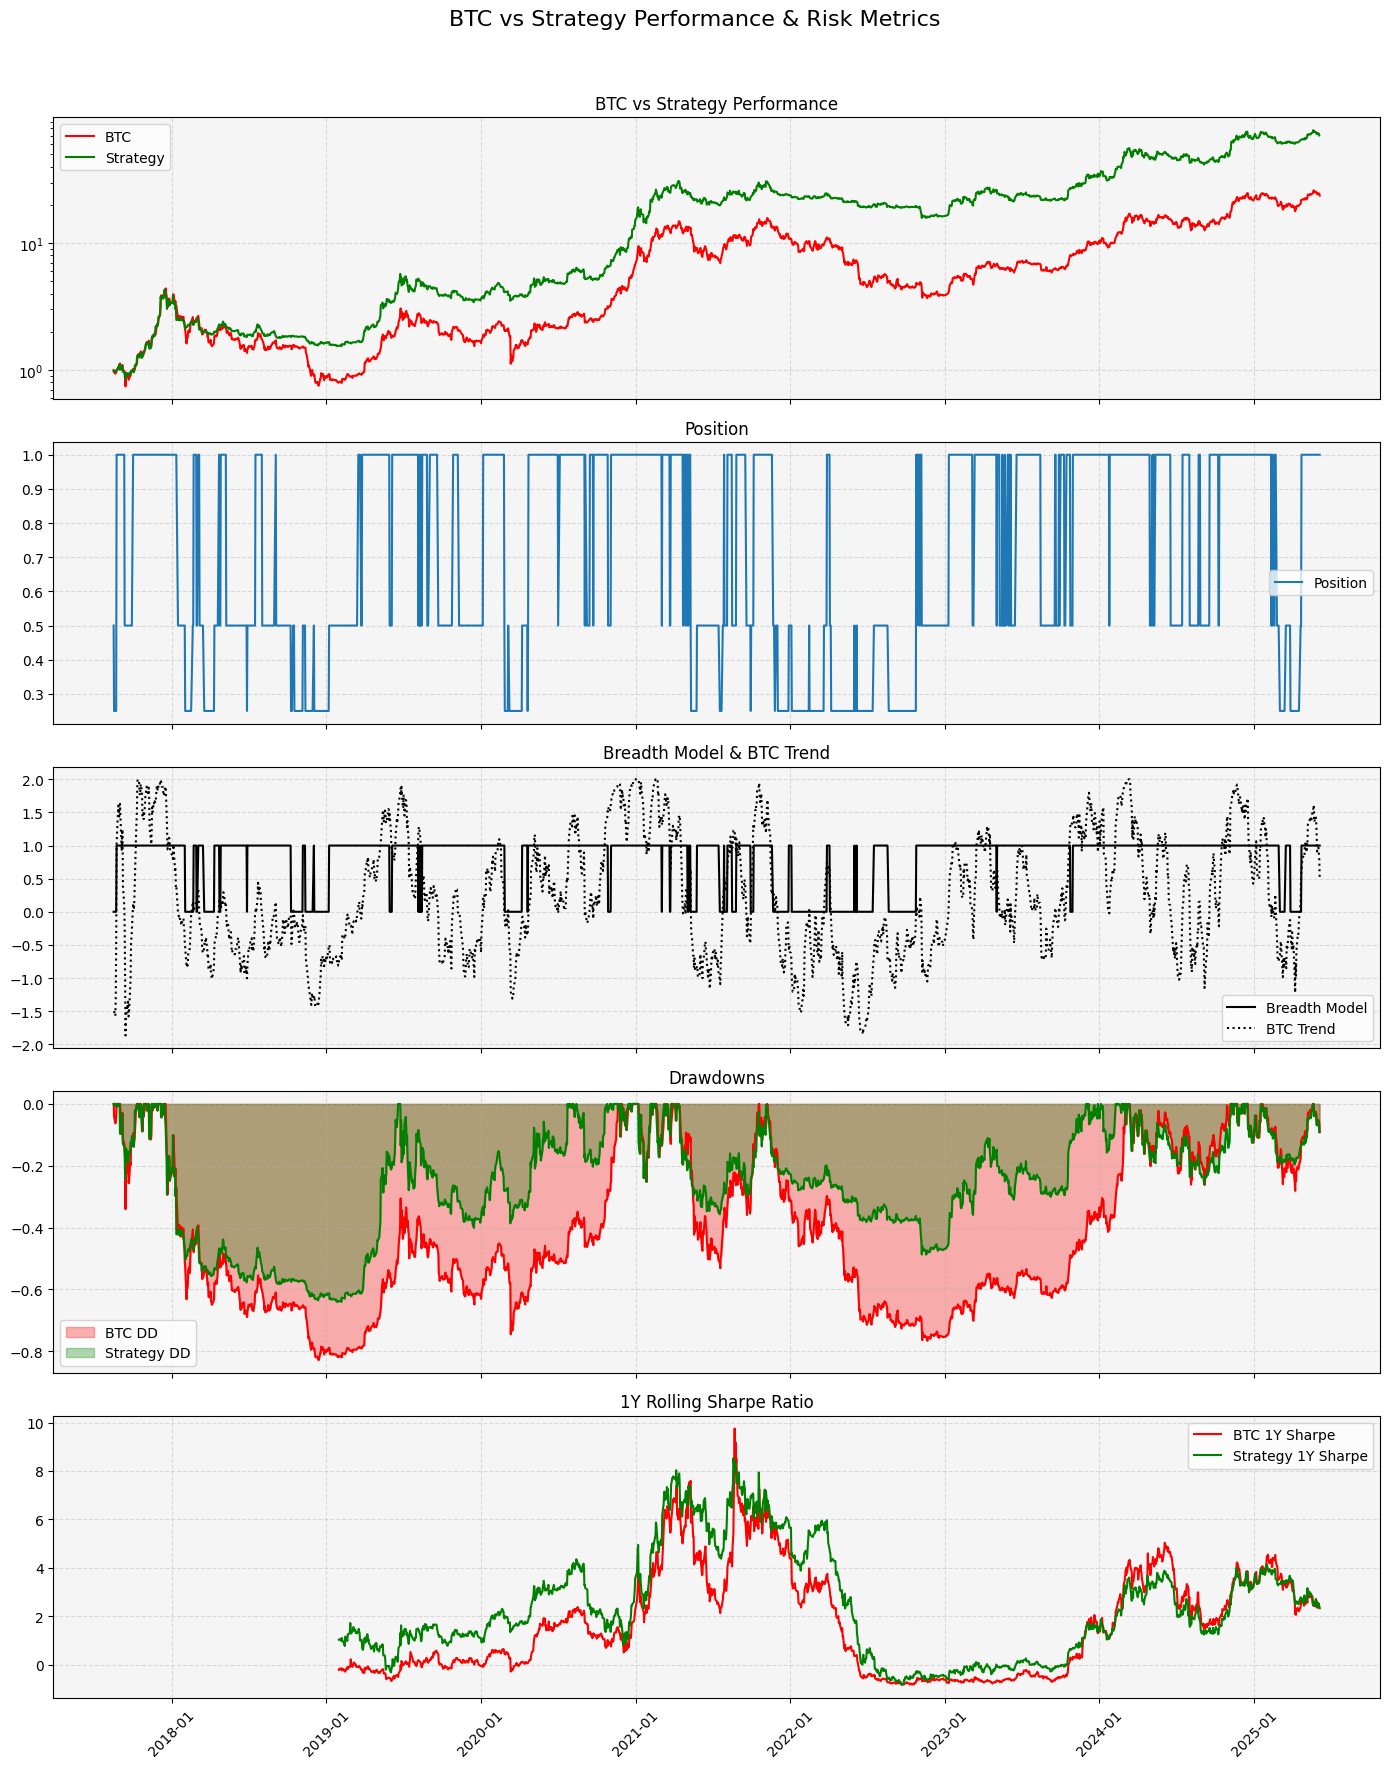

In [6]:
asset = 'BTC'

data['position'] = 1

# ----------------------
# Reduce position if SPY Breadth Model is in sell-off
mask = (data['breadth_position'] == 0)
data.loc[mask, 'position'] *= 0.5

# Reduce position if BTC Trend signal is <0
mask = (data['BTC_forecast'] < 0)
data.loc[mask, 'position'] *= 0.5

# ----------------------
data['strat_r'] = (data[f'{asset}_close'].shift(-1) / data[f'{asset}_close'] - 1) * data['position']

# 10% annualized yield on cash
data['strat_r'] += (1-data['position']) * 0.1/365

data['equity'] = (data['strat_r'] + 1).cumprod()
data['equity_rv'] = (0.3*data['BTC_close'].pct_change().ewm(span=21).std() + data['BTC_close'].pct_change().expanding().std()) * np.sqrt(365)

# --------------------------------------------------------
data['1y_cagr'] = data['equity']/data['equity'].shift(365) - 1
data['1y_rv'] = data['equity'].pct_change().ewm(span=365).std() * np.sqrt(365)
data['dd'] = (data['equity'] - data['equity'].cummax()) / data['equity'].cummax()
data['1y_sr'] = data['1y_cagr'] / data['1y_rv']

data['asset_1y_cagr'] = data[f'{asset}_close']/data[f'{asset}_close'].shift(365) - 1
data['asset_1y_rv'] = data[f'{asset}_close'].pct_change().ewm(span=365).std() * np.sqrt(365)
data['asset_dd'] = (data[f'{asset}_close'] - data[f'{asset}_close'].cummax()) / data[f'{asset}_close'].cummax()
data['asset_1y_sr'] = data['asset_1y_cagr'] / data['asset_1y_rv']

# --------------------------------------------------------
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- Crear figura y ejes
fig, axes = plt.subplots(5, 1, figsize=(14, 18), sharex=True)
plt.subplots_adjust(hspace=0.4)
fig.suptitle(f"{asset} vs Strategy Performance & Risk Metrics", fontsize=16)

# --- Subplot 1: Asset vs Strategy (log scale)
axes[0].plot(data['date'], data[f'{asset}_close'] / data[f'{asset}_close'].dropna().values[0],
             label=asset, color='red', linewidth=1.5)
axes[0].plot(data['date'], data['equity'], label='Strategy', color='green', linewidth=1.5)
axes[0].set_yscale('log')
axes[0].set_title(f"{asset} vs Strategy Performance", fontsize=12)
axes[0].legend()

# --- Subplot 2: Position
axes[1].plot(data['date'], data['position'], label='Position', linewidth=1.5)
axes[1].set_title('Position', fontsize=12)
axes[1].legend()

# --- Subplot 3: Breadth model & BTC Trend
axes[2].plot(data['date'], data['breadth_position'], label='Breadth Model', color='black', linewidth=1.5)
axes[2].plot(data['date'], data['BTC_forecast'], label='BTC Trend', color='black', linewidth=1.5, linestyle='dotted')
axes[2].set_title('Breadth Model & BTC Trend', fontsize=12)
axes[2].legend()

# --- Subplot 4: Drawdowns
axes[3].fill_between(data['date'], 0, data['asset_dd'], label=f'{asset} DD', color='red', alpha=0.3)
axes[3].plot(data['date'], data['asset_dd'], color='red', linewidth=1.5)
axes[3].fill_between(data['date'], 0, data['dd'], label='Strategy DD', color='green', alpha=0.3)
axes[3].plot(data['date'], data['dd'], color='green', linewidth=1.5)
axes[3].set_title('Drawdowns', fontsize=12)
axes[3].legend()

# --- Subplot 5: Rolling Sharpe
axes[4].plot(data['date'], data['asset_1y_sr'], label=f'{asset} 1Y Sharpe', color='red', linewidth=1.5)
axes[4].plot(data['date'], data['1y_sr'], label='Strategy 1Y Sharpe', color='green', linewidth=1.5)
axes[4].set_title('1Y Rolling Sharpe Ratio', fontsize=12)
axes[4].legend()

# --- Eje X: formato fecha
axes[-1].xaxis.set_major_locator(mdates.AutoDateLocator())
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(axes[-1].xaxis.get_majorticklabels(), rotation=45)

# --- Estilo común
for ax in axes:
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.set_facecolor('whitesmoke')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# <br><br> Comparison of scores between BTC and the strategy

In [7]:
btc_pf = vbt.Portfolio.from_signals(
    close=data['BTC_close'].dropna(),
    entries=True,
    exits=False,
    freq='1d'
)
btc_pf.stats()

Start                                          0
End                                         1960
Period                        1961 days 00:00:00
Start Value                                100.0
End Value                            2368.886462
Total Return [%]                     2268.886462
Benchmark Return [%]                 2268.886462
Max Gross Exposure [%]                     100.0
Total Fees Paid                              0.0
Max Drawdown [%]                       82.901319
Max Drawdown Duration          738 days 00:00:00
Total Trades                                   1
Total Closed Trades                            0
Total Open Trades                              1
Open Trade PnL                       2268.886462
Win Rate [%]                                 NaN
Best Trade [%]                               NaN
Worst Trade [%]                              NaN
Avg Winning Trade [%]                        NaN
Avg Losing Trade [%]                         NaN
Avg Winning Trade Du

In [8]:
stat_pf = vbt.Portfolio.from_signals(
    close=data['equity'].dropna(),
    entries=True,
    exits=False,
    freq='1d'
)
stat_pf.stats()

Start                                          0
End                                         1959
Period                        1960 days 00:00:00
Start Value                                100.0
End Value                            7194.015904
Total Return [%]                     7094.015904
Benchmark Return [%]                 7094.015904
Max Gross Exposure [%]                     100.0
Total Fees Paid                              0.0
Max Drawdown [%]                       64.039247
Max Drawdown Duration          665 days 00:00:00
Total Trades                                   1
Total Closed Trades                            0
Total Open Trades                              1
Open Trade PnL                       7094.015904
Win Rate [%]                                 NaN
Best Trade [%]                               NaN
Worst Trade [%]                              NaN
Avg Winning Trade [%]                        NaN
Avg Losing Trade [%]                         NaN
Avg Winning Trade Du